In [6]:
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, Draw, MolStandardize, PandasTools, Descriptors
from rdkit.Chem import rdFingerprintGenerator
from rdkit.Chem import rdMolDescriptors as rdmd
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.Chem.Descriptors import qed
from rdkit.ML.Cluster import Butina
import os
import ast
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import Bio
from Bio import PDB
from Bio.PDB import DSSP
from Bio.PDB import PDBIO
from Bio.PDB import PDBParser
from Bio.PDB import NACCESS
from Bio.PDB import PDBParser
from Bio.PDB.SASA import ShrakeRupley
from Bio.PDB import alphafold_db
import requests
import csv
import matplotlib.pyplot as plt

### Calculate SASA

In [ ]:
#get structure of protein from AlphaFold

def fetch_alphafold_structure(uniprot_id, dest_folder='.'):
    """Fetches AlphaFold structure given a UniProt ID and saves it to a specified folder."""
    url = f'https://alphafold.ebi.ac.uk/files/AF-{uniprot_id}-F1-model_v4.pdb'
    response = requests.get(url)
    if response.status_code == 200:
        file_path = os.path.join(dest_folder, f'AF-{uniprot_id}.pdb')
        with open(file_path, 'wb') as f:
            f.write(response.content)
        print(f"File saved: {file_path}")
        return file_path
    else:
        print(f"Failed to fetch PDB for {uniprot_id}. Status Code: {response.status_code}")
        return None

# Load UniProt IDs
df = pd.read_csv('/../PROTAC-Degradation-Predictor/data/PROTAC-Degradation-DB-2025.csv')
uniprot_ids = df['Uniprot'].dropna().unique()

output_directory = '../PROTAC-Degradation-Predictor/data/structure'
os.makedirs(output_directory, exist_ok=True)

# Loop through UniProt IDs and fetch structures
parser = PDB.PDBParser(QUIET=True)
for uniprot_id in uniprot_ids:
    pdb_file_path = fetch_alphafold_structure(uniprot_id, output_directory)
    if pdb_file_path:
        try:
            structure = parser.get_structure(uniprot_id, pdb_file_path)
            # You can add more processing here if needed
        except Exception as e:
            print(f"Error parsing structure for {uniprot_id}: {e}")

In [ ]:

# Specify the directory path containing the PDB files and output path for CSV
pdb_dir = "../PROTAC-Degradation-Predictor/data/structure"
output_csv = "../PROTAC-Degradation-Predictor/data/sasa_values_per_lys_standardized_2.csv"

# Create a PDB parser
parser = PDBParser()

# Initialize a list to store SASA values for lysine residues
lys_sasa_data = []

# Define backbone atoms to exclude
backbone_atoms = {'N', 'CA', 'C', 'O'}

# Iterate over all files in the directory
for pdb_file in os.listdir(pdb_dir):
    if pdb_file.endswith(".pdb"):
        pdb_path = os.path.join(pdb_dir, pdb_file)
        structure_id = os.path.splitext(pdb_file)[0]
        print(f"Processing {pdb_file}...")

        # Parse the structure
        structure = parser.get_structure(structure_id, pdb_path)

        # Calculate SASA using Shrake-Rupley algorithm
        sr = ShrakeRupley()
        sr.compute(structure, level="A")

        # Store SASA values for each lysine residue
        lyss_sasa_list = []
        number_of_lys = 0
        total_residue_count = 0

        for model in structure:
            for chain in model:
                for residue in chain:
                    total_residue_count += 1  # Count every residue
                    if residue.get_resname() == "LYS":
                        # Calculate SASA for non-backbone atoms
                        lys_sasa = 0.0
                        for atom in residue:
                            if atom.get_name() not in backbone_atoms and atom.sasa is not None:
                                lys_sasa += atom.sasa
                        # Append each lysine residue's SASA to the list
                        lyss_sasa_list.append(lys_sasa)
                        number_of_lys += 1

        # Add the PDB information and SASA list to our data
        if lyss_sasa_list:  # Only if list is not empty
            lys_sasa_data.append({
                'PDB File': pdb_file,
                'SASA List': lyss_sasa_list,
                'Number of Lys': number_of_lys,
                'Total Residues': total_residue_count
            })

# Flatten all SASA values to perform global normalization
all_sasa_values = [sasa for data in lys_sasa_data for sasa in data['SASA List']]
min_sasa = min(all_sasa_values)
max_sasa = max(all_sasa_values)

# Apply global normalization to each SASA list
for data in lys_sasa_data:
    data['Normalized SASA List'] = [(sasa - min_sasa) / (max_sasa - min_sasa) for sasa in data['SASA List']]

# Save SASA data with Normalized SASA to CSV
with open(output_csv, mode='w', newline='') as csvfile:
    fieldnames = ['PDB File', 'SASA List', 'Normalized SASA List', 'Number of Lys', 'Total Residues']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    for data in lys_sasa_data:
        writer.writerow(data)

#print(f"Normalized SASA data has been saved to {output_csv}.")

# Flatten all normalized SASA values for histogram plotting
all_normalized_sasa_values = [sasa for data in lys_sasa_data for sasa in data['Normalized SASA List']]
plt.figure(figsize=(8, 6))
plt.hist(all_normalized_sasa_values, bins=30, color='lightgreen', edgecolor='black')
plt.title('Distribution of Normalized SASA for Lysine Residues')
plt.xlabel('Normalized SASA')
plt.ylabel('Frequency')
plt.grid(True)

# Display the plot
plt.show()

#### plots: SASA value with distribution for Dmax or pDC50
including histogram, dense plot, box plot, scatter plot

/tmp/ipykernel_267518/1831976157.py:30: RuntimeWarning: divide by zero encountered in log10
  pDC50 = -np.log10(DC50 * 1e-9)


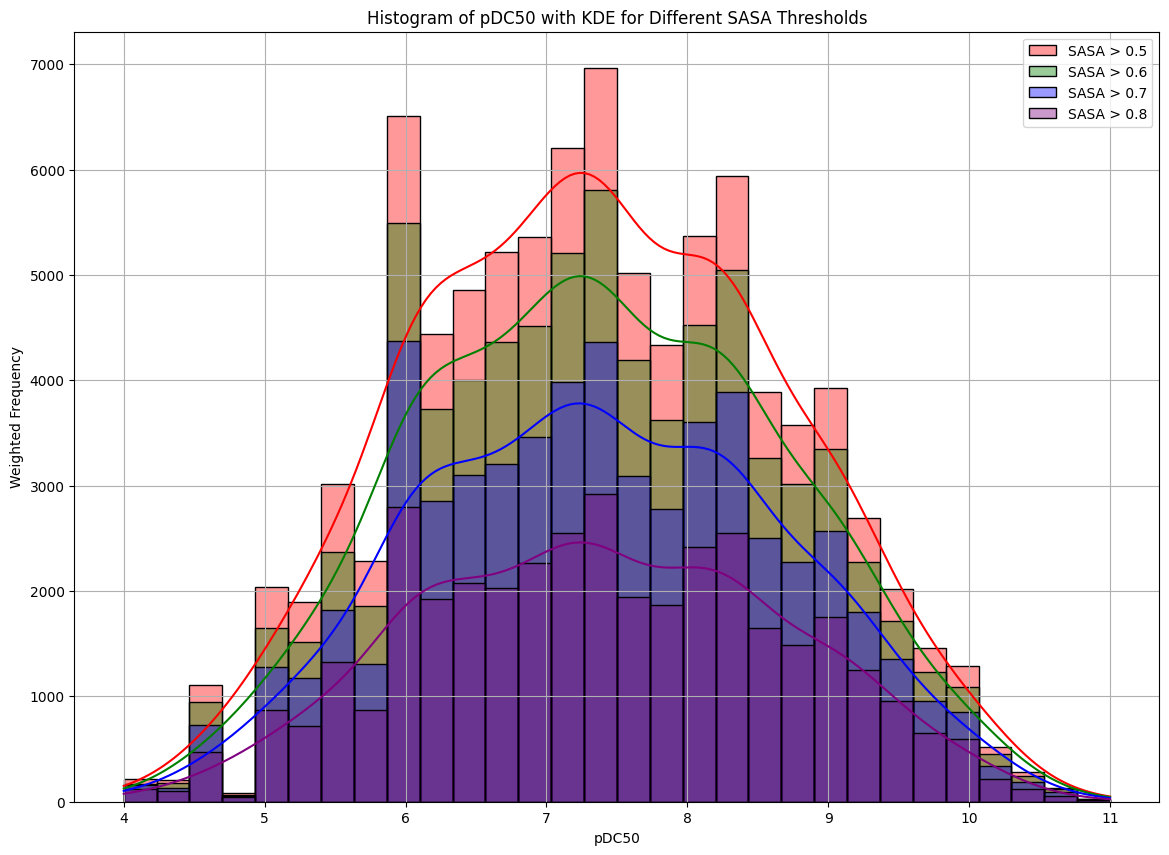

In [17]:
# Histogram with pDC50

# File paths
sasa_file = "../PROTAC-Degradation-Predictor/data/sasa_values_per_lys_standardized.csv"
dmax_file = "../PROTAC-Degradation-Predictor/data/PROTAC-Degradation-DB-2025.csv"

# Load and correct SASA data
sasa_data = []
with open(sasa_file, mode='r') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        uniprot_id = row['PDB File'].split('-')[1].split('.')[0]
        row['UniProt ID'] = uniprot_id  # Add corrected UniProt ID to each row
        sasa_data.append(row)

sasa_df = pd.DataFrame(sasa_data)

# Load DC50 data and calculate pDC50
dmax_data = {'UniProt': [], 'pDC50': []}
with open(dmax_file, mode='r') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        try:
            DC50_str = row['DC50 (nM)'].strip()
            if DC50_str:
                DC50 = float(DC50_str)
                pDC50 = -np.log10(DC50 * 1e-9)
                uniprot_id = row.get('Uniprot')
                if uniprot_id:
                    dmax_data['UniProt'].append(uniprot_id)
                    dmax_data['pDC50'].append(pDC50)
        except ValueError:
            pass

dmax_df = pd.DataFrame(dmax_data)

# Merge dataframes on UniProt ID
merged_df = pd.merge(sasa_df, dmax_df, left_on='UniProt ID', right_on='UniProt', how='inner')

# Convert relevant columns to numeric
for col in ['Count_SASA_>_0.5', 'Count_SASA_>_0.6', 'Count_SASA_>_0.7', 'Count_SASA_>_0.8']:
    merged_df[col] = pd.to_numeric(merged_df[col])

# Plotting
plt.figure(figsize=(14, 10))

# Plot histogram with KDE for each SASA count threshold
sns.histplot(data=merged_df, x='pDC50', bins=30, kde=True, 
             weights=merged_df['Count_SASA_>_0.5'], color='red', label='SASA > 0.5', alpha=0.4)
sns.histplot(data=merged_df, x='pDC50', bins=30, kde=True, 
             weights=merged_df['Count_SASA_>_0.6'], color='green', label='SASA > 0.6', alpha=0.4)
sns.histplot(data=merged_df, x='pDC50', bins=30, kde=True, 
             weights=merged_df['Count_SASA_>_0.7'], color='blue', label='SASA > 0.7', alpha=0.4)
sns.histplot(data=merged_df, x='pDC50', bins=30, kde=True, 
             weights=merged_df['Count_SASA_>_0.8'], color='purple', label='SASA > 0.8', alpha=0.4)

# Customize plot
plt.xlabel('pDC50')
plt.ylabel('Weighted Frequency')
plt.title('Histogram of pDC50 with KDE for Different SASA Thresholds')
plt.grid(True)
plt.legend()

# Show plot
plt.show()

/tmp/ipykernel_200235/1315397971.py:30: RuntimeWarning: divide by zero encountered in log10
  pDC50 = -np.log10(DC50 * 1e-9)


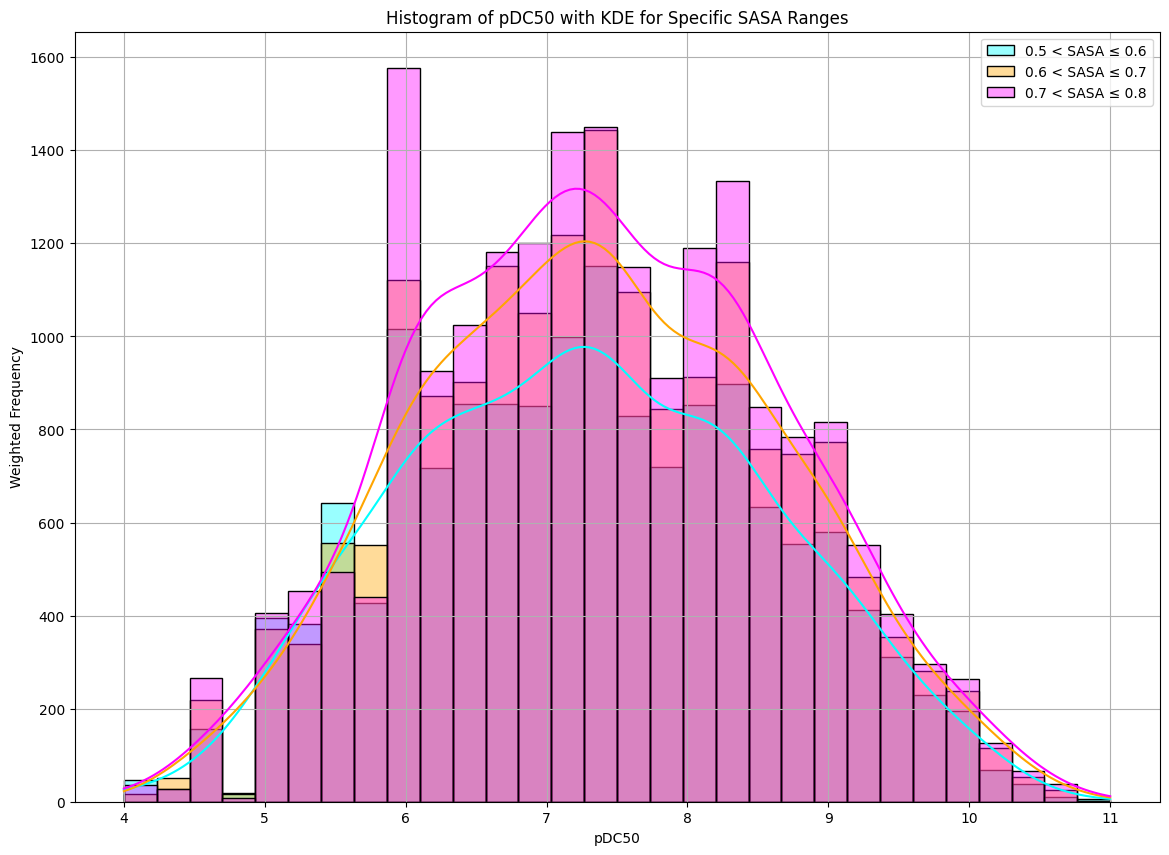

In [9]:

# File paths
sasa_file = "../PROTAC-Degradation-Predictor/data/sasa_values_per_lys_standardized.csv"
dmax_file = "../PROTAC-Degradation-Predictor/data/PROTAC-Degradation-DB-2025.csv"

# Load and correct SASA data
sasa_data = []
with open(sasa_file, mode='r') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        uniprot_id = row['PDB File'].split('-')[1].split('.')[0]
        row['UniProt ID'] = uniprot_id  # Add corrected UniProt ID to each row
        sasa_data.append(row)

sasa_df = pd.DataFrame(sasa_data)

# Load DC50 data and calculate pDC50
dmax_data = {'UniProt': [], 'pDC50': []}
with open(dmax_file, mode='r') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        try:
            DC50_str = row['DC50 (nM)'].strip()
            if DC50_str:
                DC50 = float(DC50_str)
                pDC50 = -np.log10(DC50 * 1e-9)
                uniprot_id = row.get('Uniprot')
                if uniprot_id:
                    dmax_data['UniProt'].append(uniprot_id)
                    dmax_data['pDC50'].append(pDC50)
        except ValueError:
            pass

dmax_df = pd.DataFrame(dmax_data)

# Merge dataframes on UniProt ID
merged_df = pd.merge(sasa_df, dmax_df, left_on='UniProt ID', right_on='UniProt', how='inner')

# Convert relevant columns to numeric
for col in ['Count_SASA_>_0.5', 'Count_SASA_>_0.6', 'Count_SASA_>_0.7', 'Count_SASA_>_0.8']:
    merged_df[col] = pd.to_numeric(merged_df[col])

# Calculate ranges correctly
merged_df['Count_SASA_0.5_0.6'] = merged_df['Count_SASA_>_0.5'] - merged_df['Count_SASA_>_0.6']
merged_df['Count_SASA_0.6_0.7'] = merged_df['Count_SASA_>_0.6'] - merged_df['Count_SASA_>_0.7']
merged_df['Count_SASA_0.7_0.8'] = merged_df['Count_SASA_>_0.7'] - merged_df['Count_SASA_>_0.8']

# Plotting
plt.figure(figsize=(14, 10))

# Plot histogram with KDE for each corrected SASA range
sns.histplot(data=merged_df, x='pDC50', bins=30, kde=True, 
             weights=merged_df['Count_SASA_0.5_0.6'], color='cyan', label='0.5 < SASA ≤ 0.6', alpha=0.4)
sns.histplot(data=merged_df, x='pDC50', bins=30, kde=True, 
             weights=merged_df['Count_SASA_0.6_0.7'], color='orange', label='0.6 < SASA ≤ 0.7', alpha=0.4)
sns.histplot(data=merged_df, x='pDC50', bins=30, kde=True, 
             weights=merged_df['Count_SASA_0.7_0.8'], color='magenta', label='0.7 < SASA ≤ 0.8', alpha=0.4)

# Customize plot
plt.xlabel('pDC50')
plt.ylabel('Weighted Frequency')
plt.title('Histogram of pDC50 with KDE for Specific SASA Ranges')
plt.grid(True)
plt.legend()

# Show plot
plt.show()

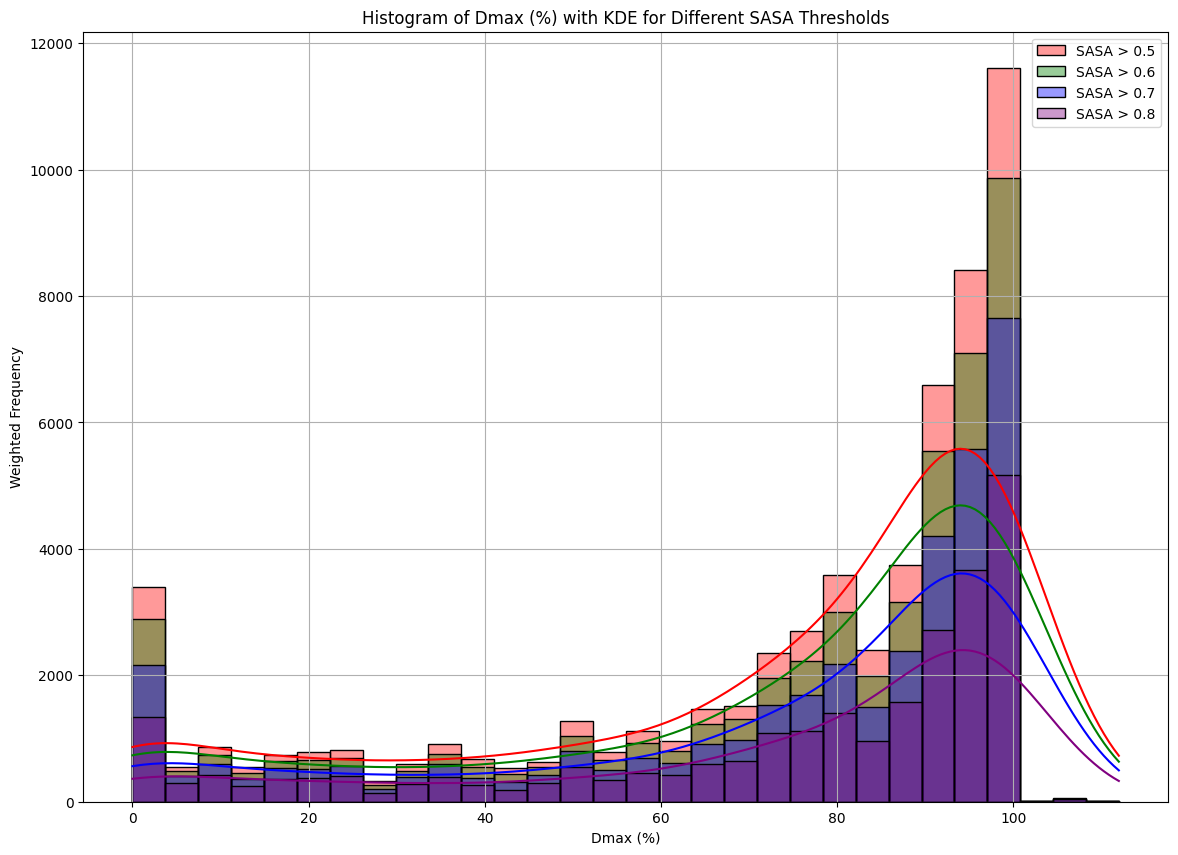

In [3]:
# Histogram for Dmax with SASA in different range
# File paths
sasa_file = "../PROTAC-Degradation-Predictor/data/sasa_values_per_lys_standardized.csv"
dmax_file = "../PROTAC-Degradation-Predictor/data/PROTAC-Degradation-DB-2025.csv"

# Load and correct SASA data
sasa_data = []
with open(sasa_file, mode='r') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        uniprot_id = row['PDB File'].split('-')[1].split('.')[0]
        row['UniProt ID'] = uniprot_id  # Add corrected UniProt ID to each row
        sasa_data.append(row)

sasa_df = pd.DataFrame(sasa_data)

# Load DC50 data and calculate pDC50
dmax_data = {'UniProt': [], 'Dmax (%)': []}
with open(dmax_file, mode='r') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        try:
            DC50_str = row['Dmax (%)'].strip()
            if DC50_str:
                pDC50 = float(DC50_str)
                
                uniprot_id = row.get('Uniprot')
                if uniprot_id:
                    dmax_data['UniProt'].append(uniprot_id)
                    dmax_data['Dmax (%)'].append(pDC50)
        except ValueError:
            pass

dmax_df = pd.DataFrame(dmax_data)

# Merge dataframes on UniProt ID
merged_df = pd.merge(sasa_df, dmax_df, left_on='UniProt ID', right_on='UniProt', how='inner')

# Convert relevant columns to numeric
for col in ['Count_SASA_>_0.5', 'Count_SASA_>_0.6', 'Count_SASA_>_0.7', 'Count_SASA_>_0.8']:
    merged_df[col] = pd.to_numeric(merged_df[col])

# Plotting
plt.figure(figsize=(14, 10))

# Plot histogram with KDE for each SASA count threshold
sns.histplot(data=merged_df, x='Dmax (%)', bins=30, kde=True, 
             weights=merged_df['Count_SASA_>_0.5'], color='red', label='SASA > 0.5', alpha=0.4)
sns.histplot(data=merged_df, x='Dmax (%)', bins=30, kde=True, 
             weights=merged_df['Count_SASA_>_0.6'], color='green', label='SASA > 0.6', alpha=0.4)
sns.histplot(data=merged_df, x='Dmax (%)', bins=30, kde=True, 
             weights=merged_df['Count_SASA_>_0.7'], color='blue', label='SASA > 0.7', alpha=0.4)
sns.histplot(data=merged_df, x='Dmax (%)', bins=30, kde=True, 
             weights=merged_df['Count_SASA_>_0.8'], color='purple', label='SASA > 0.8', alpha=0.4)

# Customize plot
plt.xlabel('Dmax (%)')
plt.ylabel('Weighted Frequency')
plt.title('Histogram of Dmax (%) with KDE for Different SASA Thresholds')
plt.grid(True)
plt.legend()

# Show plot
plt.show()

/tmp/ipykernel_211808/685898092.py:60: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x=pdc50_for_plot, y=lys_for_plot, cmap="Blues", shade=True, bw_adjust=0.5)


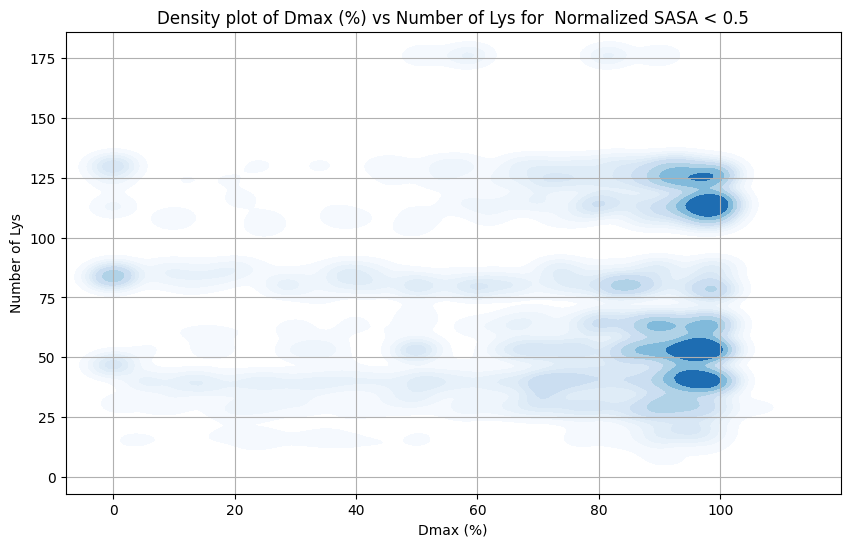

In [19]:
# Density plot

# Specify file paths for SASA results and Dmax data
sasa_file = "../PROTAC-Degradation-Predictor/data/sasa_values_with_counts.csv"
dmax_file = "../PROTAC-Degradation-Predictor/data/PROTAC-Degradation-DB-2025.csv"

# Load SASA data
sasa_data = {}
lys_data = {}
with open(sasa_file, mode='r') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        uniprot_id = row['PDB File'].split('-')[1].split('.')[0]
        sasa_list = eval(row['Normalized Adjusted SASA List'])  # Read the list of normalized SASA values
        number_of_lys = int(row['Number of Lys'])

        if uniprot_id not in sasa_data:
            sasa_data[uniprot_id] = []
            lys_data[uniprot_id] = []

        sasa_data[uniprot_id].extend(sasa_list)
        lys_data[uniprot_id].extend([number_of_lys] * len(sasa_list))

# Load DC50 data
dmax_data = {}
with open(dmax_file, mode='r') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        try:
            DC50_str = row['Dmax (%)'].strip()
            if DC50_str:
                DC50 = float(DC50_str)
                pDC50 = DC50
                uniprot_id = row.get('Uniprot')
                if uniprot_id:
                    if uniprot_id not in dmax_data:
                        dmax_data[uniprot_id] = []
                    dmax_data[uniprot_id].append(DC50)
        except ValueError:
            pass

# Prepare data for density plot
lys_for_plot = []
pdc50_for_plot = []

for uniprot_id in sasa_data.keys():
    if uniprot_id in dmax_data:
        for i, n_sasa in enumerate(sasa_data[uniprot_id]):
            if  n_sasa < 0.5: # Condition for SASA values greater than 0.7
                pDC50_list = dmax_data[uniprot_id]
                for pDC50 in pDC50_list:
                    lys_for_plot.append(lys_data[uniprot_id][i])
                    pdc50_for_plot.append(pDC50)

# Plotting density plot
plt.figure(figsize=(10, 6))
sns.kdeplot(x=pdc50_for_plot, y=lys_for_plot, cmap="Blues", shade=True, bw_adjust=0.5)
plt.xlabel('Dmax (%)')
plt.ylabel('Number of Lys')
plt.title('Density plot of Dmax (%) vs Number of Lys for  Normalized SASA < 0.5')
plt.grid(True)
plt.show()

Skipping empty DC50 value for UniProt ID: Q07817
Skipping empty DC50 value for UniProt ID: Q07817
Skipping empty DC50 value for UniProt ID: Q07817
Skipping empty DC50 value for UniProt ID: Q07817
Skipping empty DC50 value for UniProt ID: Q07817
Skipping empty DC50 value for UniProt ID: Q07817
Skipping empty DC50 value for UniProt ID: Q07817
Skipping empty DC50 value for UniProt ID: Q07817
Skipping empty DC50 value for UniProt ID: Q07817
Skipping empty DC50 value for UniProt ID: Q07817
Skipping empty DC50 value for UniProt ID: Q07817
Skipping empty DC50 value for UniProt ID: Q07817
Skipping empty DC50 value for UniProt ID: Q07817
Skipping empty DC50 value for UniProt ID: Q07817
Skipping empty DC50 value for UniProt ID: Q07817
Skipping empty DC50 value for UniProt ID: Q07817
Skipping empty DC50 value for UniProt ID: Q07817
Skipping empty DC50 value for UniProt ID: Q07817
Skipping empty DC50 value for UniProt ID: Q07817
Skipping empty DC50 value for UniProt ID: Q07817
Skipping empty DC50 

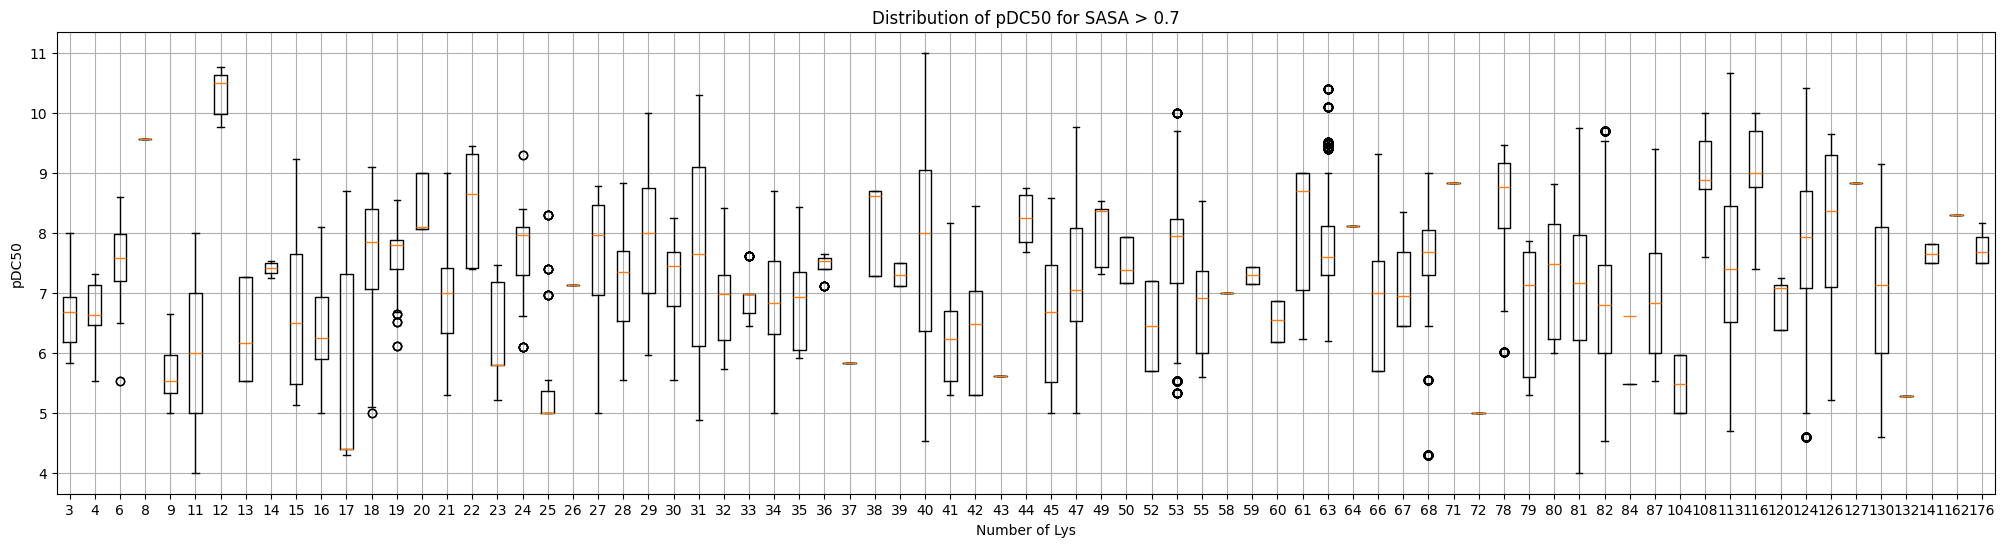

In [9]:
# Box plot for pDC50

import warnings
warnings.filterwarnings("ignore")
# File paths
sasa_file = "../PROTAC-Degradation-Predictor/data/sasa_values_per_lys_standardized.csv"
dmax_file = "../PROTAC-Degradation-Predictor/data/PROTAC-Degradation-DB-2025.csv"

# Load SASA data
sasa_data = {}
lys_data = {}
with open(sasa_file, mode='r') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        uniprot_id = row['PDB File'].split('-')[1].split('.')[0]
        sasa_list = eval(row['Normalized SASA List'])
        number_of_lys = int(row['Number of Lys'])

        if uniprot_id not in sasa_data:
            sasa_data[uniprot_id] = []
            lys_data[uniprot_id] = []

        sasa_data[uniprot_id].extend(sasa_list)
        lys_data[uniprot_id].extend([number_of_lys] * len(sasa_list))

# Load DC50 data
dmax_data = {}
with open(dmax_file, mode='r') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        try:
            DC50_str = row['DC50 (nM)'].strip()
            if DC50_str:
                DC50 = float(DC50_str)
                pDC50 = -np.log10(DC50 * 1e-9)
                uniprot_id = row.get('Uniprot')
                if uniprot_id:
                    if uniprot_id not in dmax_data:
                        dmax_data[uniprot_id] = []
                    dmax_data[uniprot_id].append(pDC50)
            else:
                print(f"Skipping empty DC50 value for UniProt ID: {row['Uniprot']}")
        except ValueError:
            print(f"Skipping invalid DC50 value: {DC50_str} for UniProt ID: {row['Uniprot']}")

# Organize data for box plot: n_sasa greater than 0.7
box_plot_data = {}
for uniprot_id in sasa_data.keys():
    if uniprot_id in dmax_data:
        for i, n_sasa in enumerate(sasa_data[uniprot_id]):
            if n_sasa > 0.7:
                number_of_lys = lys_data[uniprot_id][i]
                pDC50_list = dmax_data[uniprot_id]
                if number_of_lys not in box_plot_data:
                    box_plot_data[number_of_lys] = []
                box_plot_data[number_of_lys].extend(pDC50_list)
# Plotting box plot
plt.figure(figsize=(25, 6))
lys_labels, data = zip(*sorted(box_plot_data.items()))  # Sort by number of lysines
plt.boxplot(data, labels=lys_labels)

plt.xlabel('Number of Lys')
plt.ylabel('pDC50')
plt.title('Distribution of pDC50 for SASA > 0.7')
plt.grid(True)
plt.show()

Skipping empty Dmax (%) value for UniProt ID: Q07817
Skipping empty Dmax (%) value for UniProt ID: Q07817
Skipping empty Dmax (%) value for UniProt ID: Q07817
Skipping empty Dmax (%) value for UniProt ID: Q07817
Skipping empty Dmax (%) value for UniProt ID: Q07817
Skipping empty Dmax (%) value for UniProt ID: Q07817
Skipping empty Dmax (%) value for UniProt ID: Q07817
Skipping empty Dmax (%) value for UniProt ID: Q07817
Skipping empty Dmax (%) value for UniProt ID: Q07817
Skipping empty Dmax (%) value for UniProt ID: Q07817
Skipping empty Dmax (%) value for UniProt ID: Q07817
Skipping empty Dmax (%) value for UniProt ID: Q07817
Skipping empty Dmax (%) value for UniProt ID: Q07817
Skipping empty Dmax (%) value for UniProt ID: Q07817
Skipping empty Dmax (%) value for UniProt ID: Q07817
Skipping empty Dmax (%) value for UniProt ID: Q07817
Skipping empty Dmax (%) value for UniProt ID: Q07817
Skipping empty Dmax (%) value for UniProt ID: Q07817
Skipping empty Dmax (%) value for UniProt ID: 

/tmp/ipykernel_280684/945521153.py:71: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=lys_labels)


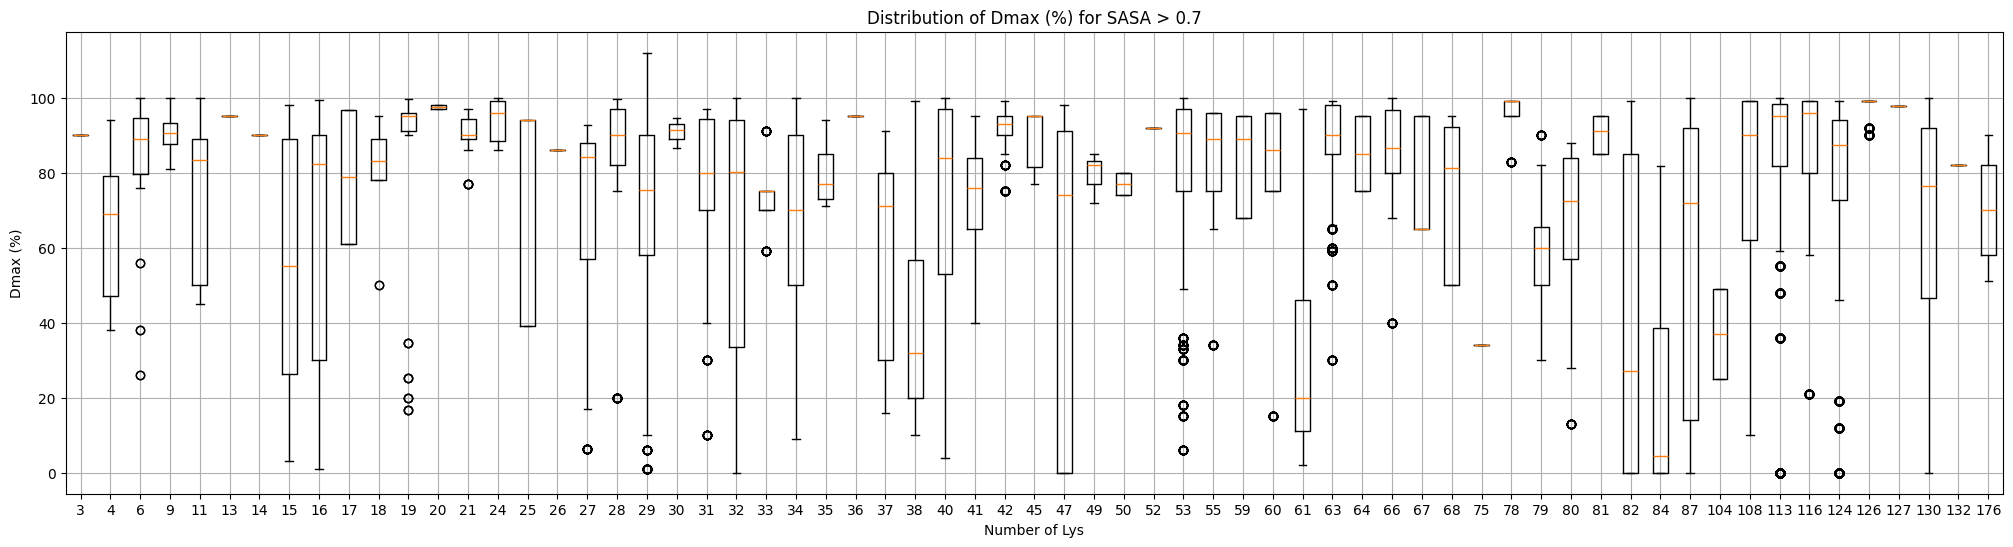

In [3]:
# Box plot for Dmax

# File paths
sasa_file = "../PROTAC-Degradation-Predictor/data/sasa_values_per_lys_standardized.csv"
dmax_file = "../PROTAC-Degradation-Predictor/data/PROTAC-Degradation-DB-2025.csv"

# Load SASA data
sasa_data = {}
lys_data = {}
with open(sasa_file, mode='r') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        uniprot_id = row['PDB File'].split('-')[1].split('.')[0]
        sasa_list = eval(row['Normalized SASA List'])
        number_of_lys = int(row['Number of Lys'])

        if uniprot_id not in sasa_data:
            sasa_data[uniprot_id] = []
            lys_data[uniprot_id] = []

        sasa_data[uniprot_id].extend(sasa_list)
        lys_data[uniprot_id].extend([number_of_lys] * len(sasa_list))

# Load DC50 data
dmax_data = {}
with open(dmax_file, mode='r') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        try:
            DC50_str = row['Dmax (%)'].strip()
            if DC50_str:
                DC50 = float(DC50_str)
                pDC50 = DC50
                uniprot_id = row.get('Uniprot')
                if uniprot_id:
                    if uniprot_id not in dmax_data:
                        dmax_data[uniprot_id] = []
                    dmax_data[uniprot_id].append(pDC50)
            else:
                print(f"Skipping empty Dmax (%) value for UniProt ID: {row['Uniprot']}")
        except ValueError:
            print(f"Skipping invalid Dmax (%) value: {DC50_str} for UniProt ID: {row['Uniprot']}")

# Organize data: n_sasa > 0.7 and prepare for box plot
box_plot_data = {}
count_data = {}
for uniprot_id in sasa_data.keys():
    if uniprot_id in dmax_data:
        for i, n_sasa in enumerate(sasa_data[uniprot_id]):
            if n_sasa > 0.7:
                number_of_lys = lys_data[uniprot_id][i]
                pDC50_list = dmax_data[uniprot_id]

                if number_of_lys not in box_plot_data:
                    box_plot_data[number_of_lys] = []
                    count_data[number_of_lys] = 0

                box_plot_data[number_of_lys].extend(pDC50_list)
                count_data[number_of_lys] += 1

# Print the count of elements used for each lysine number
print("Counts of n_sasa > 0.7 for each lysine number:")
for number_of_lys, count in count_data.items():
    print(f"Lys {number_of_lys}: {count} entries")

# Plotting box plot
plt.figure(figsize=(25, 6))
lys_labels, data = zip(*sorted(box_plot_data.items()))  # Sort by number of lysines
plt.boxplot(data, labels=lys_labels)

plt.xlabel('Number of Lys')
plt.ylabel('Dmax (%)')
plt.title('Distribution of Dmax (%) for SASA > 0.7')
plt.grid(True)
plt.show()


Skipping invalid DC50 value:  for UniProt ID: Q07817
Skipping invalid DC50 value:  for UniProt ID: Q07817
Skipping invalid DC50 value:  for UniProt ID: Q07817
Skipping invalid DC50 value:  for UniProt ID: Q07817
Skipping invalid DC50 value:  for UniProt ID: Q07817
Skipping invalid DC50 value:  for UniProt ID: Q07817
Skipping invalid DC50 value:  for UniProt ID: Q07817
Skipping invalid DC50 value:  for UniProt ID: Q07817
Skipping invalid DC50 value:  for UniProt ID: Q07817
Skipping invalid DC50 value:  for UniProt ID: Q07817
Skipping invalid DC50 value:  for UniProt ID: Q07817
Skipping invalid DC50 value:  for UniProt ID: Q07817
Skipping invalid DC50 value:  for UniProt ID: Q07817
Skipping invalid DC50 value:  for UniProt ID: Q07817
Skipping invalid DC50 value:  for UniProt ID: Q07817
Skipping invalid DC50 value:  for UniProt ID: Q07817
Skipping invalid DC50 value:  for UniProt ID: Q07817
Skipping invalid DC50 value:  for UniProt ID: Q07817
Skipping invalid DC50 value:  for UniProt ID: 

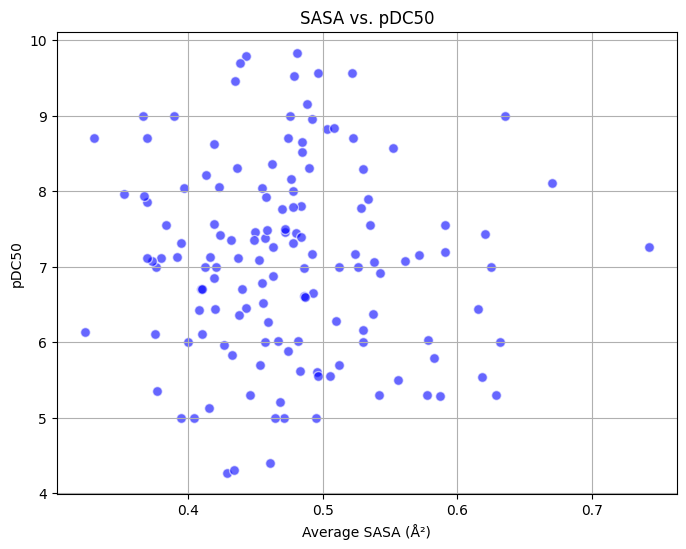

In [17]:
# scatter plot for SASA

# Specify file paths for SASA results and Dmax data
sasa_file = "../PROTAC-Degradation-Predictor/data/lys_sasa_values_standardized.csv"
dmax_file = "../PROTAC-Degradation-Predictor/data/PROTAC-Degradation-DB-2025.csv"

# Load SASA data
sasa_data = {}
with open(sasa_file, mode='r') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        # Extract UniProt ID from PDB file name assuming format like AF-Q07817
        uniprot_id = row['PDB File'].split('-')[1].split('.')[0]  
        sasa = float(row['Normalized SASA'])
        if uniprot_id not in sasa_data:
            sasa_data[uniprot_id] = []
        sasa_data[uniprot_id].append(sasa)

# Calculate average SASA for each UniProt ID
averaged_sasa = {uniprot_id: sum(sasas) / len(sasas) for uniprot_id, sasas in sasa_data.items()}

# Load Dmax data
dmax_data = {}
with open(dmax_file, mode='r') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        try:
            DC50 = float(row['DC50 (nM)'].strip())
            pDC50 = -np.log10(DC50 * 1e-9) if DC50 else np.nan
            if uniprot_id := row.get('Uniprot'):
                dmax_data[uniprot_id] = pDC50
        except ValueError:
            print(f"Skipping invalid DC50 value: {row['DC50 (nM)']} for UniProt ID: {row['Uniprot']}")

# Prepare lists for plotting
x_sasa = []
y_pdmax = []
for uniprot_id in averaged_sasa:
    if uniprot_id in dmax_data:
        x_sasa.append(averaged_sasa[uniprot_id])
        y_pdmax.append(dmax_data[uniprot_id])

# Plot SASA vs. pDC50
plt.figure(figsize=(8, 6))
plt.scatter(x_sasa, y_pdmax, c='blue', alpha=0.6, edgecolors='w', s=50)
plt.title('SASA vs. pDC50')
plt.xlabel('Average SASA (Å²)')
plt.ylabel('pDC50')
plt.grid(True)

# Display the plot
plt.show()

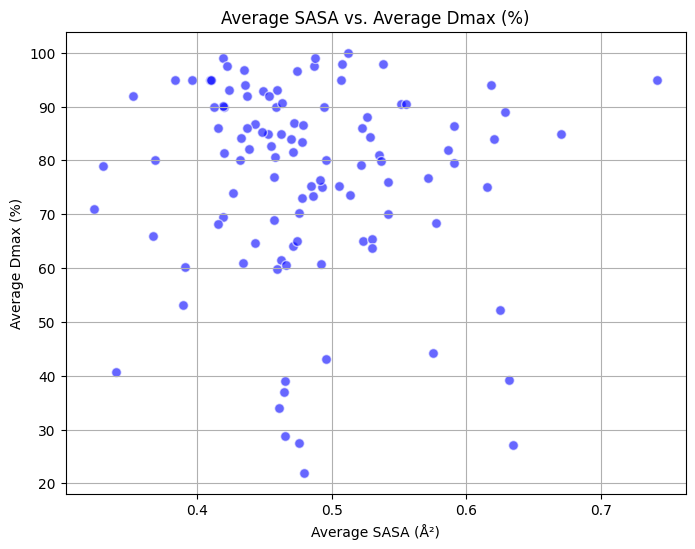

In [13]:
import csv
import matplotlib.pyplot as plt
import pandas as pd

# Specify file paths for SASA results and Dmax data
sasa_file = "../PROTAC-Degradation-Predictor/data/lys_sasa_values_standardized.csv"
dmax_file = "../PROTAC-Degradation-Predictor/data/PROTAC-Degradation-DB-2025.csv"

# Load SASA data
sasa_data = {}
with open(sasa_file, mode='r') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        # Extract UniProt ID from PDB file name assuming format like AF-Q07817
        uniprot_id = row['PDB File'].split('-')[1].split('.')[0]  
        sasa = float(row['Normalized SASA'])
        if uniprot_id not in sasa_data:
            sasa_data[uniprot_id] = []
        sasa_data[uniprot_id].append(sasa)

# Calculate average SASA for each UniProt ID
averaged_sasa = {uniprot_id: sum(sasas) / len(sasas) for uniprot_id, sasas in sasa_data.items()}

# Load Dmax data using pandas
dmax_df = pd.read_csv(dmax_file)

# Calculate average Dmax for each UniProt ID
averaged_dmax = dmax_df.groupby('Uniprot')['Dmax (%)'].mean().reset_index()

# Prepare lists for plotting
x_sasa = []
y_dmax = []

for _, row in averaged_dmax.iterrows():
    uniprot_id = row['Uniprot']
    if uniprot_id in averaged_sasa:
        x_sasa.append(averaged_sasa[uniprot_id])
        y_dmax.append(row['Dmax (%)'])

# Plot SASA vs. Average Dmax
plt.figure(figsize=(8, 6))
plt.scatter(x_sasa, y_dmax, c='blue', alpha=0.6, edgecolors='w', s=50)
plt.title('Average SASA vs. Average Dmax (%)')
plt.xlabel('Average SASA (Å²)')
plt.ylabel('Average Dmax (%)')
plt.grid(True)

# Display the plot
plt.show()

### Baseline Plots

In [2]:

df= pd.read_csv('../PROTAC-Degradation-Predictor/data/PROTAC-Degradation-DB-2025-sequence.csv')
df['Uniprot'].nunique()

159

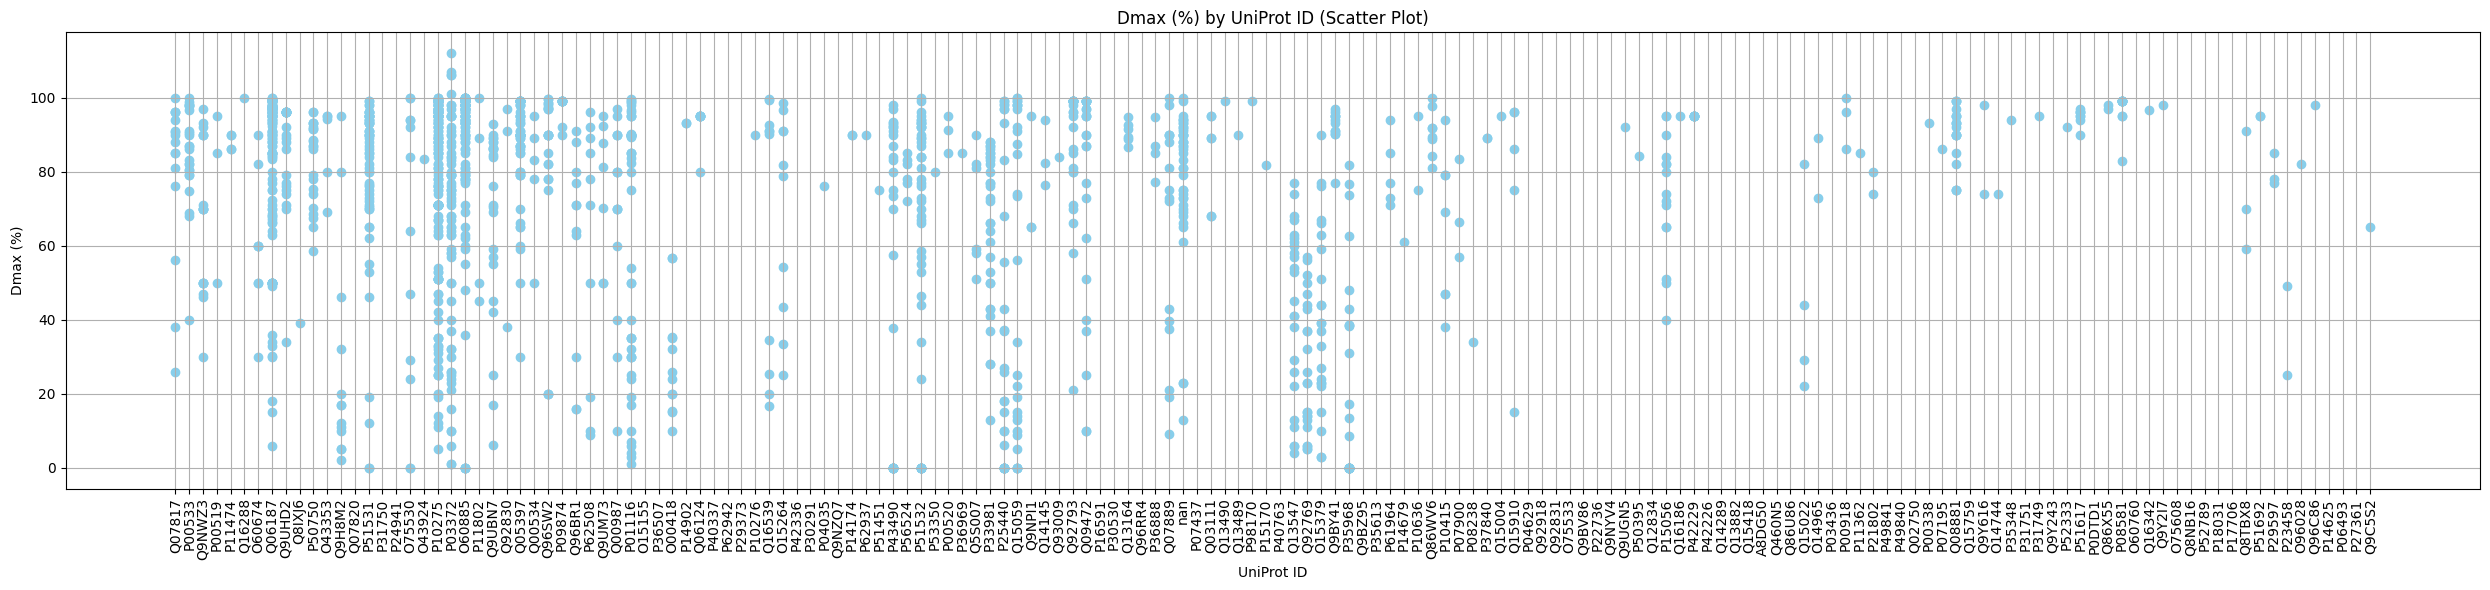

In [28]:
# Dmax distribution
df['Uniprot'] = df['Uniprot'].astype(str)

plt.figure(figsize=(25, 6))
plt.scatter(df['Uniprot'], df['Dmax (%)'], color='skyblue')

plt.xlabel('UniProt ID')
plt.ylabel('Dmax (%)')
plt.title('Dmax (%) by UniProt ID (Scatter Plot)')
plt.xticks(rotation=90)  
plt.tight_layout()  
plt.grid(True)  
plt.show()

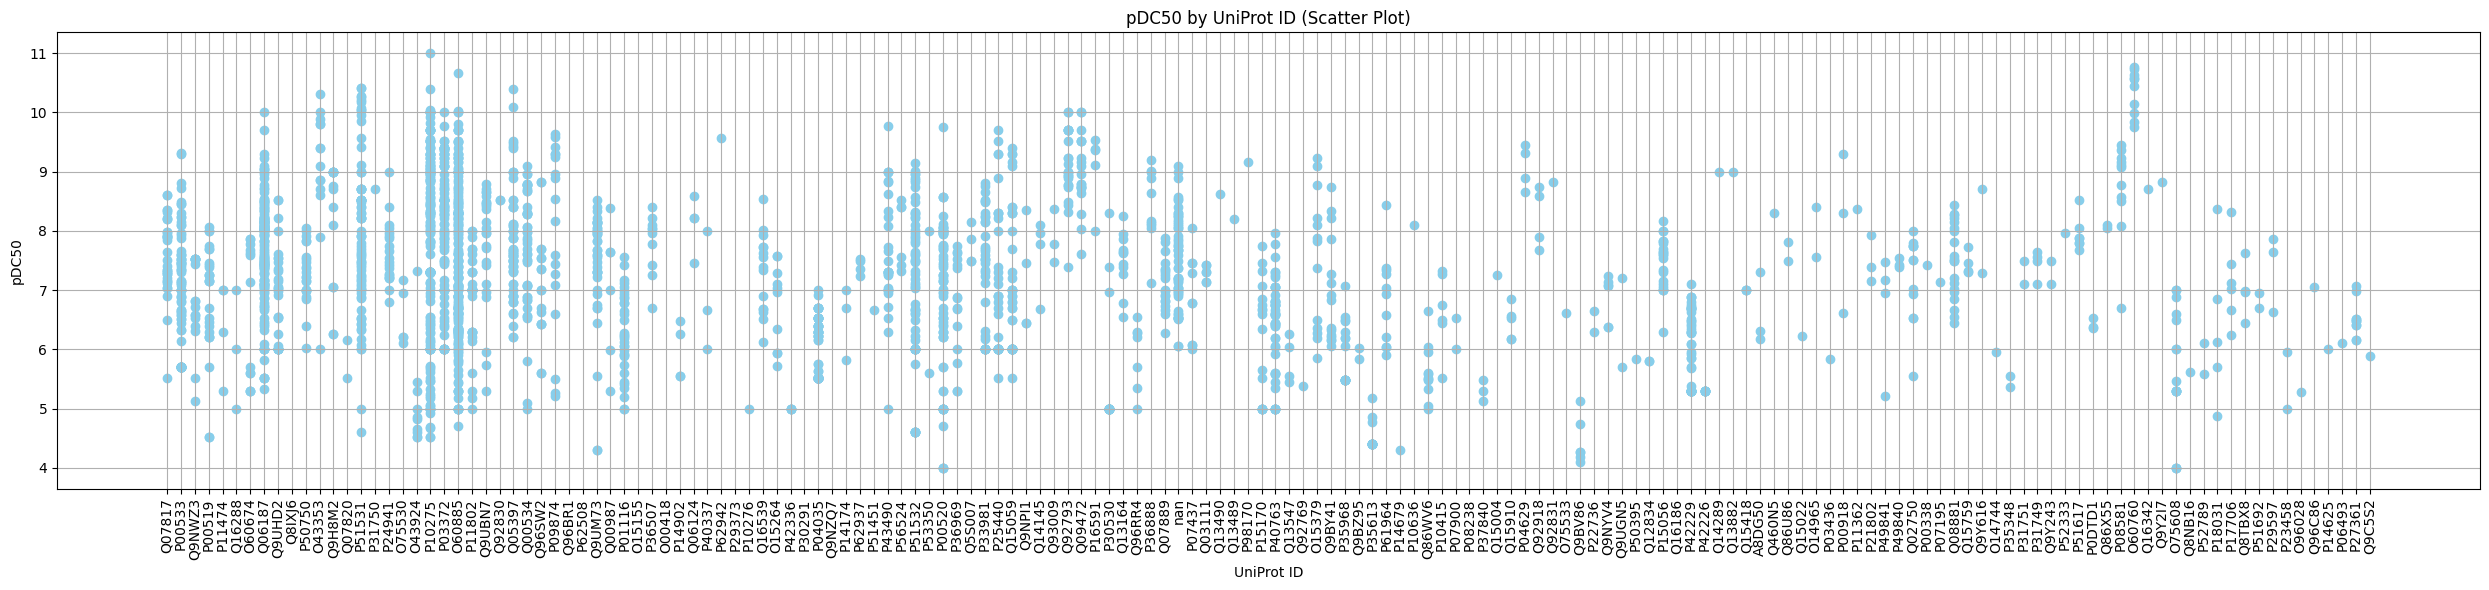

In [30]:
# pDC50 distribution
df['pDC50'] = -np.log10(df['DC50 (nM)'] * 1e-9)
df['Uniprot'] = df['Uniprot'].astype(str)

plt.figure(figsize=(25, 6))
plt.scatter(df['Uniprot'], df['pDC50'], color='skyblue')

plt.xlabel('UniProt ID')
plt.ylabel('pDC50')
plt.title('pDC50 by UniProt ID (Scatter Plot)')
plt.xticks(rotation=90)  
plt.tight_layout()  
plt.grid(True)  
plt.show()

#### Define and calculate R value by SASA and plot

In [37]:
##combine the dataframe for sasa and df according to Uniprot
sasa_df=pd.read_csv('../PROTAC-Degradation-Predictor/data/sasa_values_per_lys_standardized_2.csv') 
sasa_df['Uniprot'] = sasa_df['PDB File'].apply(lambda row: row.split('-')[1].split('.')[0])
sasa_df = sasa_df[['Uniprot', 'Normalized SASA List', 'Number of Lys', 'Total Residues']]
combined_df = pd.merge(df, sasa_df, on='Uniprot', how='left')   

In [32]:
output_file_path = '../PROTAC-Degradation-Predictor/data/PROTAC_combined_sasa.csv'  
combined_df.to_csv(output_file_path, index=False)

In [4]:
#Define R value and Calculate

combined_df=pd.read_csv('../PROTAC-Degradation-Predictor/data/PROTAC_combined_sasa.csv')

thresholds = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]


def calculate_counts(sasa_list, threshold):
    return sum(1 for sasa_value in sasa_list if sasa_value > threshold)

for threshold in thresholds:
    # 使用 eval 直接转换字符串为列表，计算 Count Above
    combined_df[f'Count_Above_{threshold}'] = combined_df['Normalized SASA List'].apply(lambda x: calculate_counts(eval(x) if isinstance(x, str) else [], threshold))
    
    # 计算 Count Below
    combined_df[f'Count_Below_{threshold}'] = combined_df['Normalized SASA List'].apply(lambda x: len(eval(x) if isinstance(x, str) else []) - calculate_counts(eval(x) if isinstance(x, str) else [], threshold))

    # 计算 R 值，并处理除以零的情况
    combined_df[f'R_{threshold}'] = combined_df[f'Count_Above_{threshold}'] / (combined_df['Total Residues'].replace(0, float('nan')))
    #combined_df[f'R_{threshold}'] = combined_df[f'Count_Above_{threshold}'] / (combined_df[f'Count_Below_{threshold}'].replace(0, float('nan')))
    (combined_df['Number of Lys'].replace(0, float('nan')))
    combined_df[f'R_{threshold}'] = combined_df[f'R_{threshold}'].fillna(0)


In [3]:
combined_df.columns

Index(['Unnamed: 0', 'Compound ID', 'Uniprot', 'Smiles', 'E3 Ligase', 'InChI',
       'InChI Key', 'Molecular Weight', 'Heavy Atom Count', 'Ring Count',
       'Rotatable Bond Count', 'Topological Polar Surface Area',
       'Hydrogen Bond Acceptor Count', 'Hydrogen Bond Donor Count',
       'Cell Type', 'Treatment Time (h)', 'DC50 (nM)', 'Dmax (%)', 'Active',
       'Article DOI', 'Comments', 'Database', 'Molecular Formula', 'cLogP',
       'Target', 'PDB', 'Name', 'Assay (DC50/Dmax)', 'Exact Mass', 'XLogP3',
       'Target (Parsed)', 'POI Sequence', 'E3 Ligase Uniprot',
       'E3 Ligase Sequence', 'Cell Line Identifier', 'Active - OR', 'pDC50',
       'Normalized SASA List', 'Number of Lys', 'Total Residues',
       'Count_Above_0.2', 'Count_Below_0.2', 'R_0.2', 'Count_Above_0.3',
       'Count_Below_0.3', 'R_0.3', 'Count_Above_0.4', 'Count_Below_0.4',
       'R_0.4', 'Count_Above_0.5', 'Count_Below_0.5', 'R_0.5',
       'Count_Above_0.6', 'Count_Below_0.6', 'R_0.6', 'Count_Above_0.

In [7]:
max_total_residues = combined_df['Total Residues'].max()
print(f'Maximum Total Residues: {max_total_residues}')

max_total_residues = combined_df['Dmax (%)'].max()
print(f'Maximum Dmax (%): {max_total_residues}')

Maximum Total Residues: 2527.0


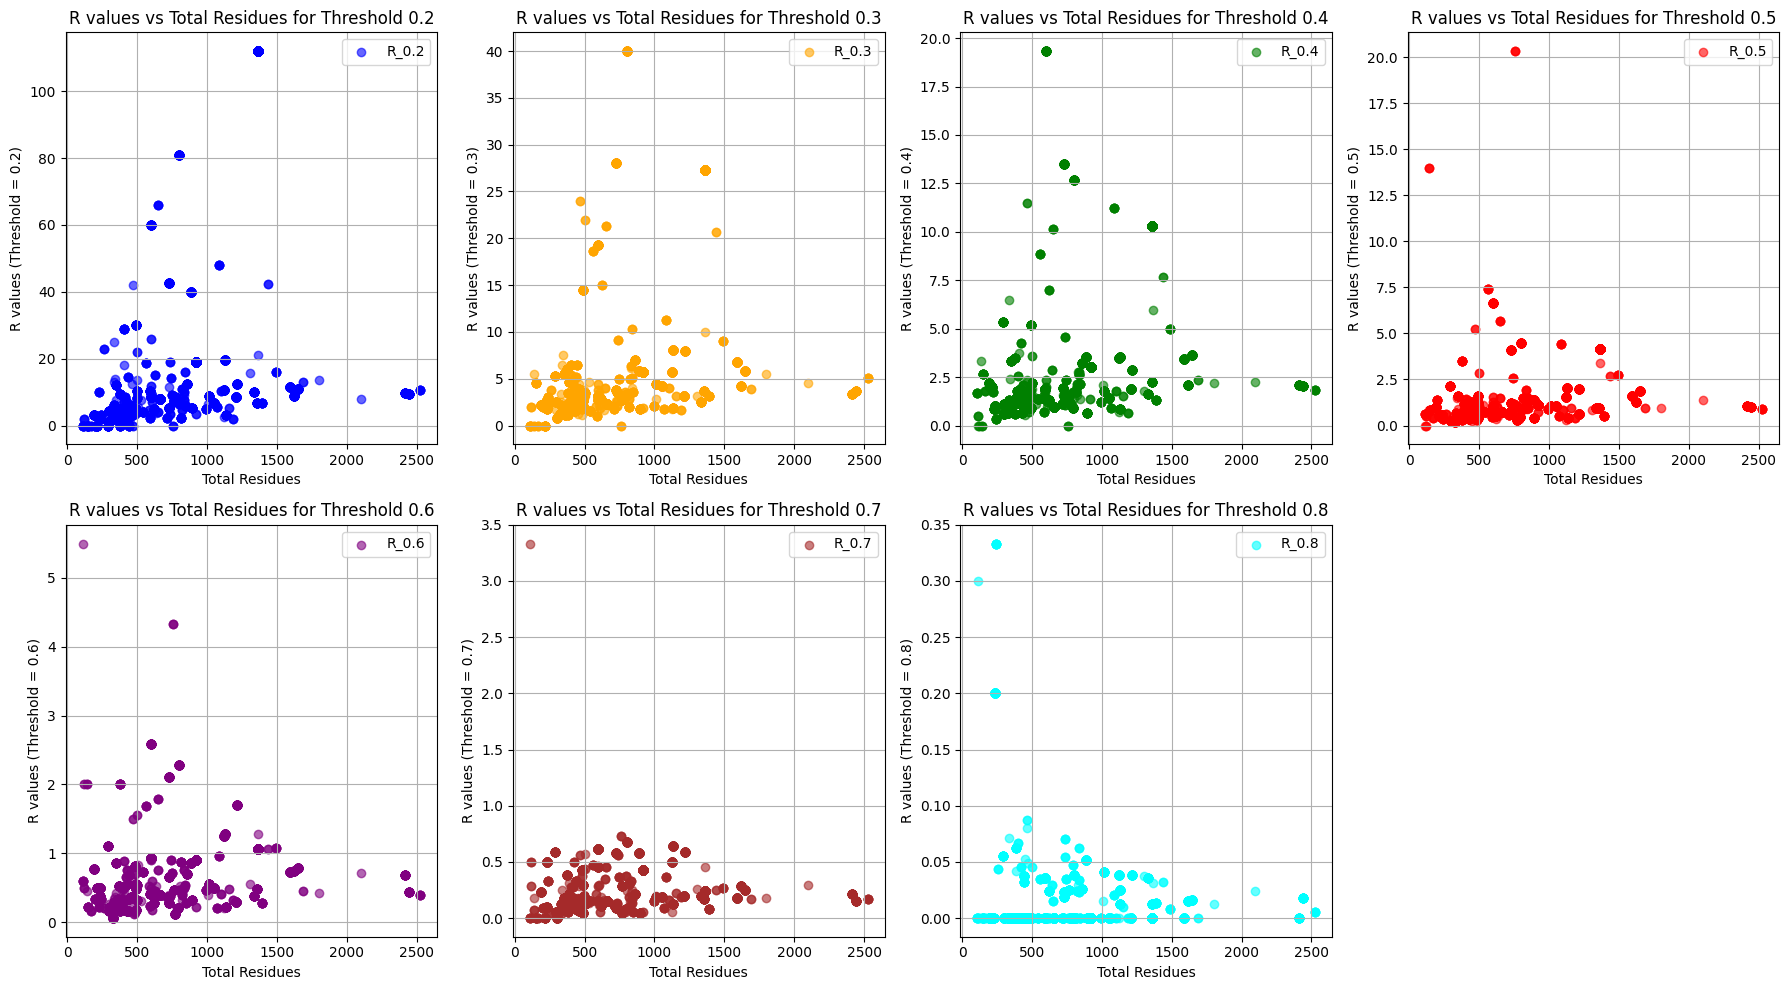

In [18]:
# Check if R value have relationship with total residue number

thresholds = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'cyan']

fig, axs = plt.subplots(2, 4, figsize=(18, 10))  

axs = axs.flatten()

for i, (threshold, color) in enumerate(zip(thresholds, colors)):
    axs[i].scatter(combined_df['Total Residues'], combined_df[f'R_{threshold}'], color=color, label=f'R_{threshold}', alpha=0.6)
    axs[i].set_xlabel('Total Residues')
    axs[i].set_ylabel(f'R values (Threshold = {threshold})')
    axs[i].set_title(f'R values vs Total Residues for Threshold {threshold}')
    axs[i].legend()
    axs[i].grid(True)

axs[-1].axis('off')  
plt.tight_layout()
plt.show()

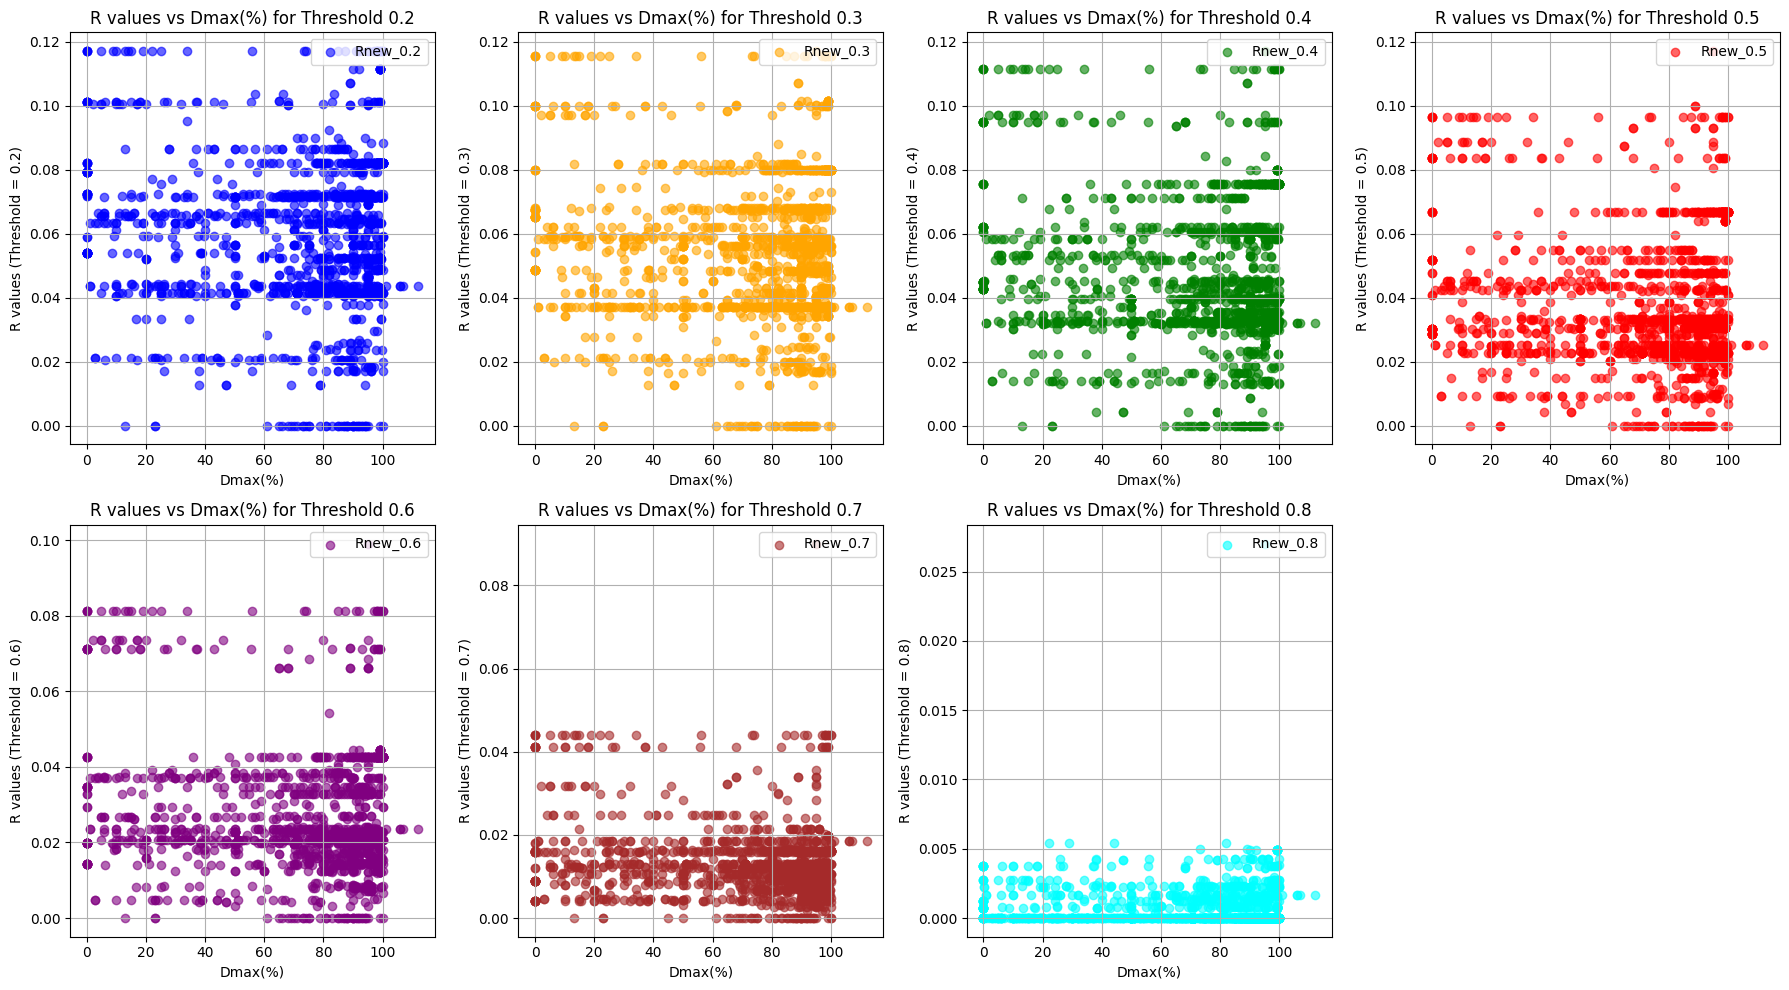

In [6]:
# R value with every Dmax value 
thresholds = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'cyan']

fig, axs = plt.subplots(2, 4, figsize=(18, 10))  

axs = axs.flatten()

for i, (threshold, color) in enumerate(zip(thresholds, colors)):
    axs[i].scatter(combined_df['Dmax (%)'], combined_df[f'Rnew_{threshold}'], color=color, label=f'Rnew_{threshold}', alpha=0.6) # Dmax have multiple value per Uniprot
    axs[i].set_xlabel('Dmax(%)')
    axs[i].set_ylabel(f'R values (Threshold = {threshold})')
    axs[i].set_title(f'R values vs Dmax(%) for Threshold {threshold}')
    axs[i].legend(loc='upper right')
    axs[i].grid(True)

axs[-1].axis('off')  

plt.tight_layout()
plt.show()

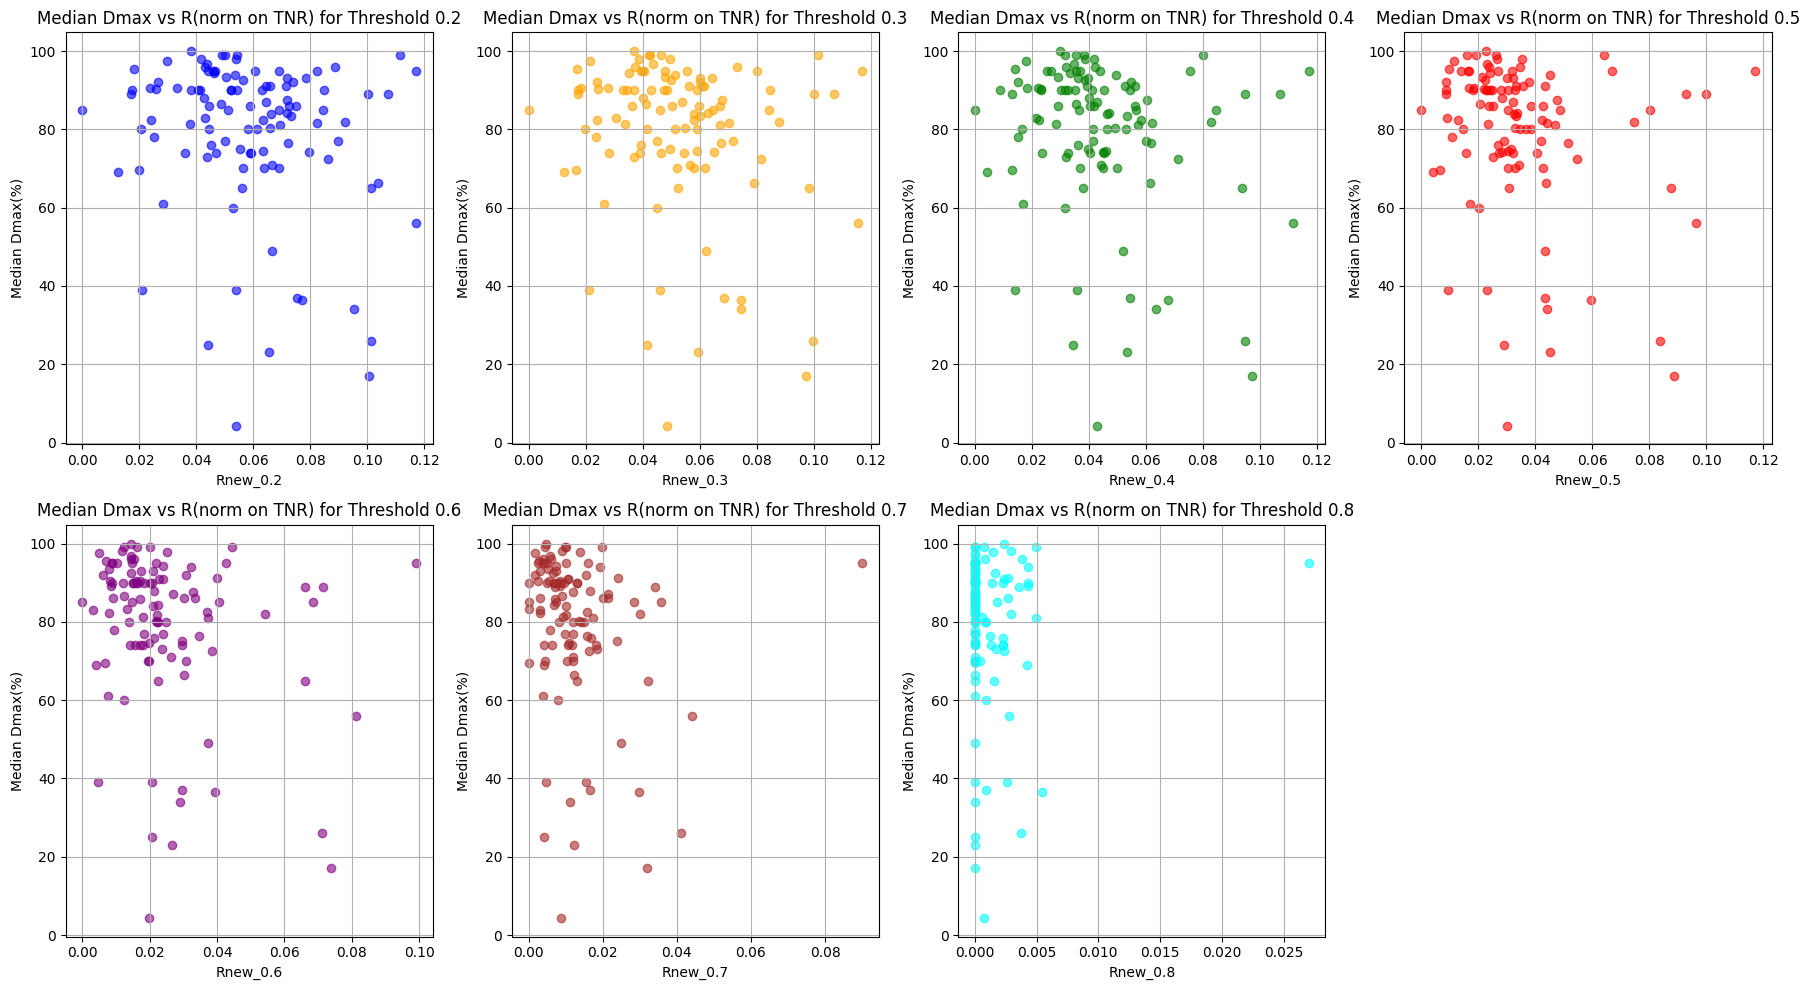

In [10]:
# R value with Median Dmax 

# Calculate the median Dmax for each Uniprot
median_dmax = combined_df.groupby('Uniprot')['Dmax (%)'].median().reset_index()
median_dmax.rename(columns={'Dmax (%)': 'Median Dmax (%)'}, inplace=True)

# Extract the consistent Rnew values for each Uniprot for every threshold
rnew_values = combined_df[['Uniprot'] + [f'R_{threshold}' for threshold in thresholds]].drop_duplicates()

# Merge the DataFrames to include median Dmax
plot_df = median_dmax.merge(rnew_values, on='Uniprot')

# Create subplots
fig, axs = plt.subplots(2, 4, figsize=(18, 10))
axs = axs.flatten()

# Plot for each threshold
for i, (threshold, color) in enumerate(zip(thresholds, colors)):
    axs[i].scatter(plot_df[f'R_{threshold}'], plot_df['Median Dmax (%)'], color=color, alpha=0.6)
    axs[i].set_xlabel(f'R_{threshold}')
    axs[i].set_ylabel('Median Dmax(%)')
    axs[i].set_title(f'Median Dmax vs R(norm on TNR) for Threshold {threshold}')
    axs[i].grid(True)

# Hide the last subplot if it remains empty
axs[-1].axis('off')

# Adjust layout for readability
plt.tight_layout()
plt.show()

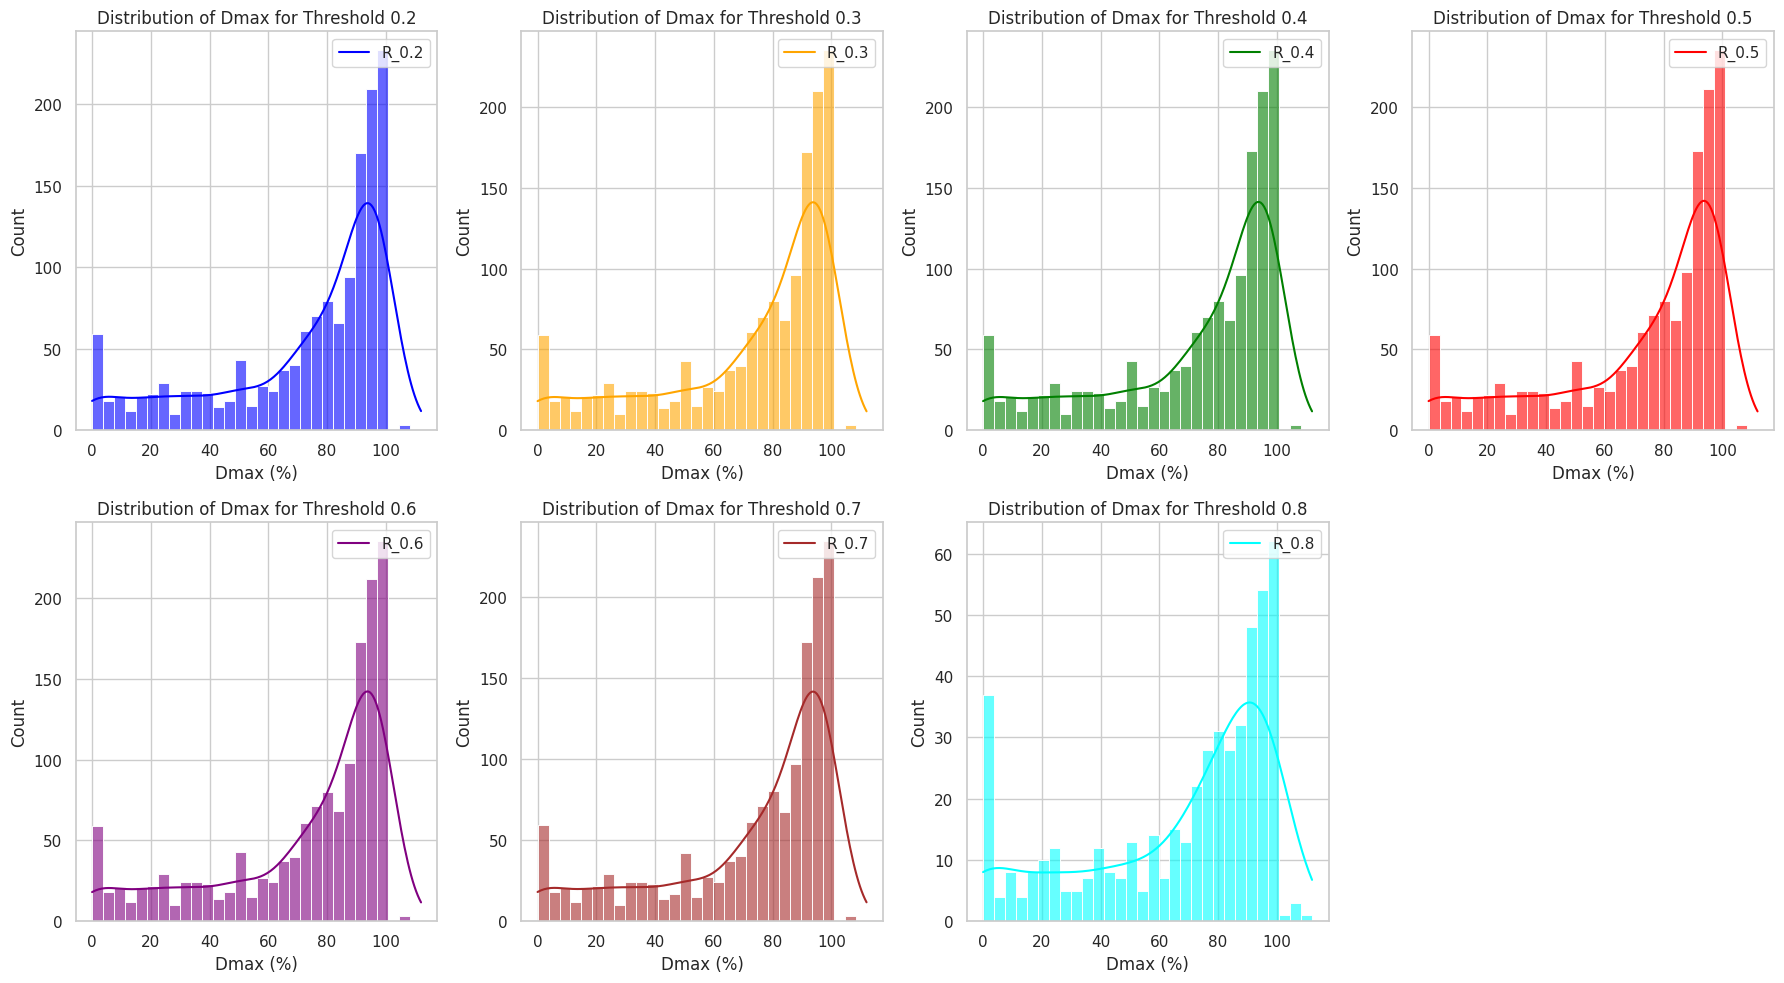

In [24]:
#histogram
thresholds = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'cyan']

fig, axs = plt.subplots(2, 4, figsize=(18, 10))  

axs = axs.flatten()

for i, (threshold, color) in enumerate(zip(thresholds, colors)):
    valid_r_values = combined_df[f'R_{threshold}']
    dmax_values = combined_df['Dmax (%)']

    sns.histplot(dmax_values[valid_r_values > 0], bins=30, kde=True, color=color, ax=axs[i], stat='count', alpha=0.6)

    axs[i].set_xlabel('Dmax (%)')
    axs[i].set_ylabel('Count')
    axs[i].set_title(f'Distribution of Dmax for Threshold {threshold}')
    axs[i].legend([f'R_{threshold}'], loc='upper right')
    axs[i].grid(True)

axs[-1].axis('off') 

plt.tight_layout()
plt.show()

### Normalize Dmax and plot with R value

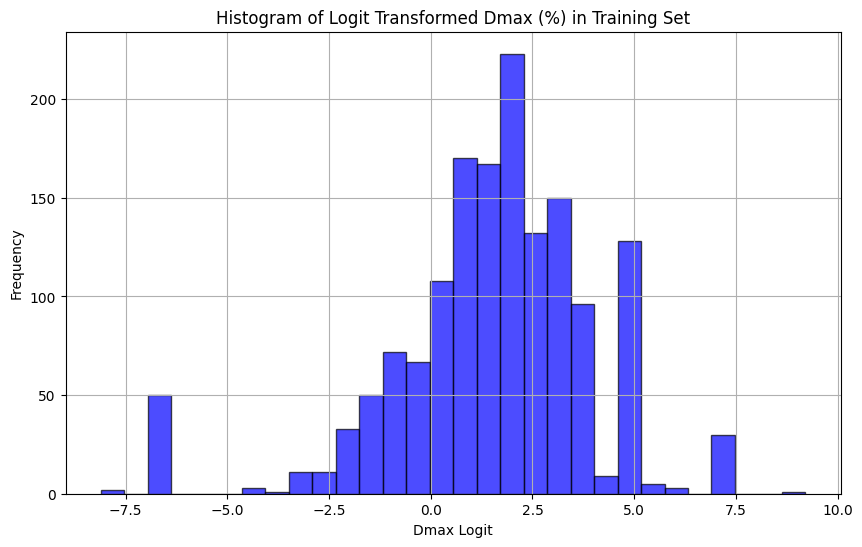

In [5]:
# Normalize Dmax
df = pd.read_csv('../PROTAC-Degradation-Predictor/data/PROTAC_combined_sasa.csv')

df = df[df['Dmax (%)'] <= 100]

df['Dmax_normalized'] = df['Dmax (%)'] / 100

df['Dmax_normalized'] = df['Dmax_normalized'].apply(lambda x: 0.999 if x == 1 else (0.001 if x == 0 else x))

df['Dmax_logit'] = np.log(df['Dmax_normalized'] / (1 - df['Dmax_normalized']))

plt.figure(figsize=(10, 6))
plt.hist(df['Dmax_logit'], bins=30, alpha=0.7, color='blue', edgecolor='black')
plt.xlabel('Dmax Logit')
plt.ylabel('Frequency')
plt.title('Histogram of Logit Transformed Dmax (%) in Training Set')
plt.grid(True)
plt.show()

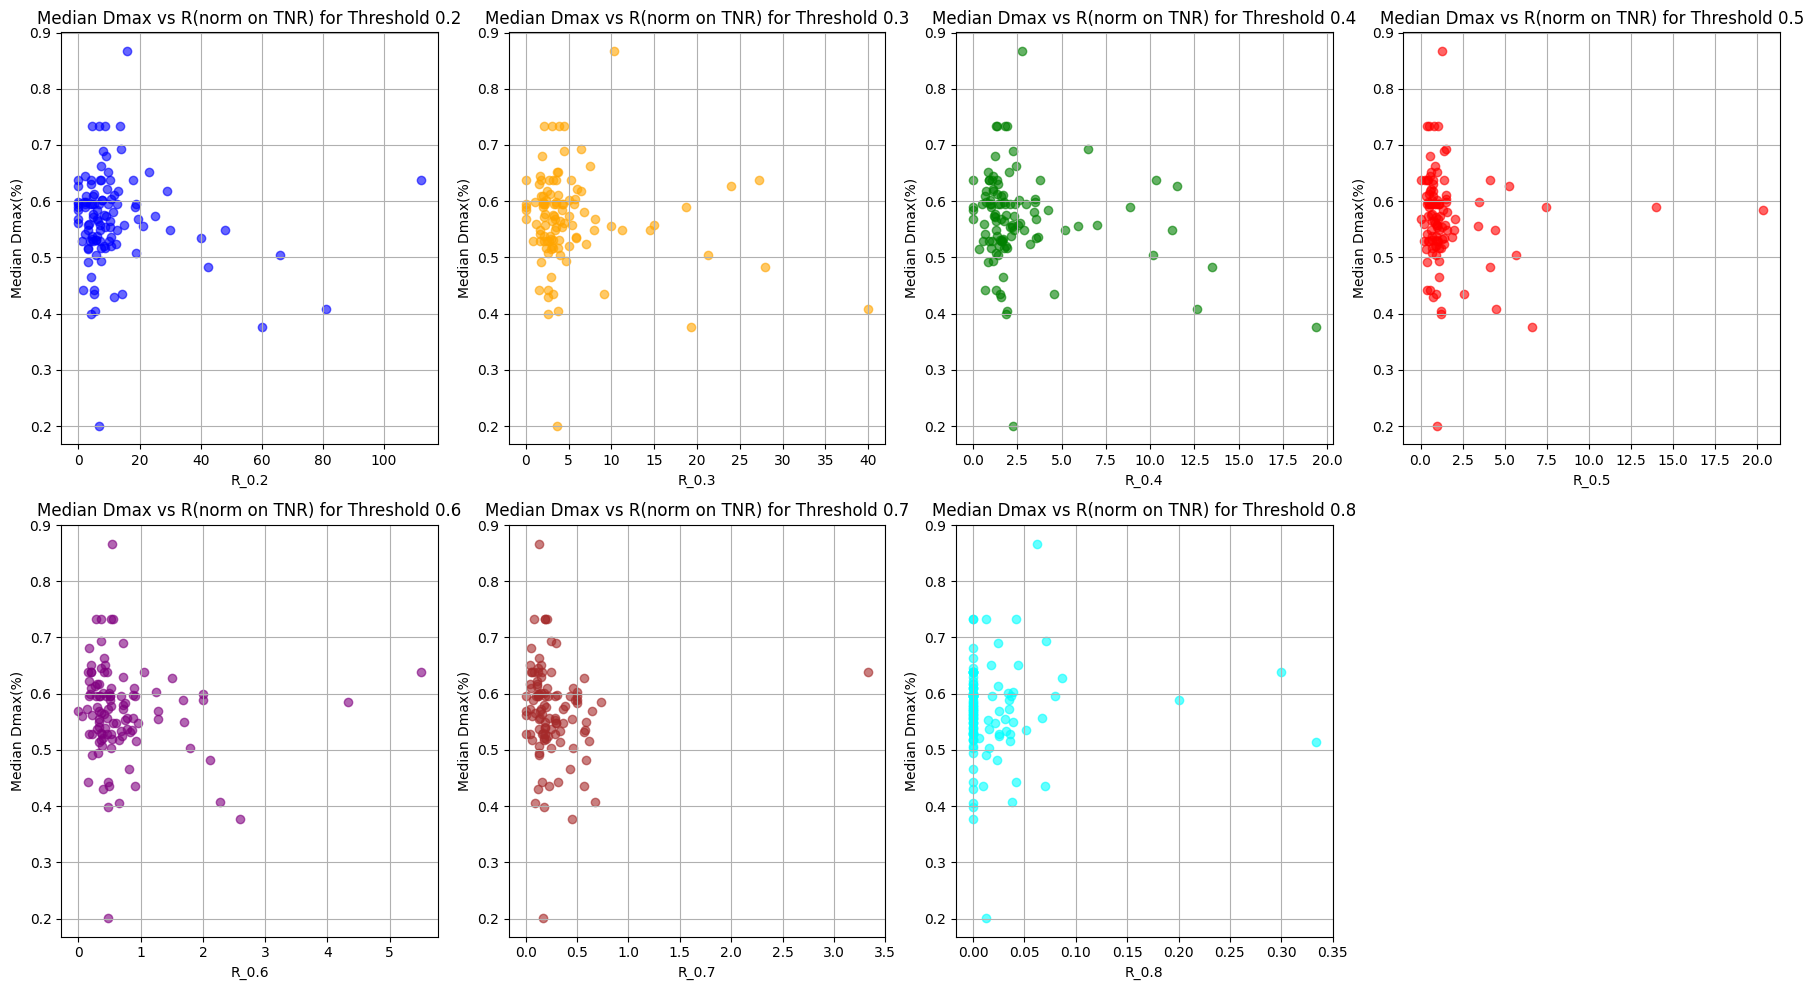

In [12]:
# R value with normalized Dmax 

# Same plotting method as above

median_dmax = combined_df.groupby('Uniprot')['Dmax_logit_normalized'].median().reset_index()
median_dmax.rename(columns={'Dmax_logit_normalized': 'Median Dmax (%)'}, inplace=True)
rnew_values = combined_df[['Uniprot'] + [f'R_{threshold}' for threshold in thresholds]].drop_duplicates()

plot_df = median_dmax.merge(rnew_values, on='Uniprot')

fig, axs = plt.subplots(2, 4, figsize=(18, 10))
axs = axs.flatten()

for i, (threshold, color) in enumerate(zip(thresholds, colors)):
    axs[i].scatter(plot_df[f'R_{threshold}'], plot_df['Median Dmax (%)'], color=color, alpha=0.6)
    axs[i].set_xlabel(f'R_{threshold}')
    axs[i].set_ylabel('Median Dmax(%)')
    axs[i].set_title(f'Median Dmax vs R(norm on TNR) for Threshold {threshold}')
    axs[i].grid(True)

axs[-1].axis('off')

plt.tight_layout()
plt.show()